In [1]:
!pip install nltk
!pip install torch
!pip install fasttext
!pip install sklearn-hierarchical-classification
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install prettytable

In [ ]:
!pip install transformers

In [2]:
import torch
import torch.nn as nn

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ongwe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
''' 
Preprocess Data
'''

import re
import nltk
import string
import fasttext
from keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize

OTHER_TAG = "other"
PUNCT_TAG = "punct"

with open('./utils/tags.txt', encoding="utf-8", errors='ignore') as f:
    tags = set([str.rstrip(tag) for tag in f.readlines()])

with open('./utils/tags_hierarchy.txt', encoding="utf-8", errors='ignore') as f:
    hierarchy_tags = set([str.rstrip(tag) for tag in f.readlines()])

def remove_labels(text):
    return re.sub(r'\<\/?[\w-]*\>\s*', "", text).strip()

def tag_token(token, tag):
    if token in string.punctuation:
        return (token, PUNCT_TAG)
    return (token, tag)

def get_tagged_tokens(ref, groups):
    tagged_tokens = []
    relevant_groups = list(filter(lambda group: group[1] in tags, groups))
    tag_dict = dict()
    for group in relevant_groups:
        text = remove_labels(group[0])
        tokens = word_tokenize(text)
        for token in tokens:
            if token not in tag_dict:
                tag_dict[token] = [group[1]]
            else:
                tag_dict[token].append(group[1])
    tokenized_ref = word_tokenize(remove_labels(ref))
    tagged_tokens = []
    for token in tokenized_ref:
        if token in tag_dict and tag_dict[token]: # still has a tag
            tag = tag_dict[token][0]
            tag_dict[token].pop(0)
        else:
            tag = OTHER_TAG
        tagged_tokens.append(tag_token(token, tag))
    return tagged_tokens

def find_groups(text):
    groups = re.findall(r'(\<(.*)\>.*\<\/\2\>)', text) # group: (<tag> ... <tag>, tag)
    if not groups:
        return []
    combined = []
    for group in groups:
        new_group = re.sub(r'\<\/?'+ group[1] + '\>\s*', "", group[0]).strip()
        combined.append(group)
        combined.extend(find_groups(new_group))
    return combined

''' Attach tags to each token '''
def attach_tags(dataset_path):
    dataset = []
    with open(dataset_path, encoding="utf-8", errors='ignore') as f:
        refs = f.readlines()
        for ref in refs:
            groups = find_groups(ref)
            # groups = re.findall(r'(\<(.*)\>.*\<\/\2\>)', ref) # format (<tag>...</tag>, tag)
            tagged_tokens = get_tagged_tokens(ref, groups)
            dataset.append(tagged_tokens)
    return dataset

''' Removes labels and tokenizes '''
def tokenize_dataset(dataset_path, sep=" "):
    dataset = []
    with open(dataset_path, encoding="utf-8", errors='ignore') as f:
        refs = f.readlines()
        for ref in refs:
            ref = remove_labels(ref) 
            tokenized = sep.join(word_tokenize(ref))
            dataset.append(tokenized)
    return dataset

def map_to_index(keys, idx_start=0):
    key_to_idx, keys_arr, idx = {}, [], idx_start
    for key in keys:
        key_to_idx[key] = idx
        keys_arr.append(key)
        idx += 1
    return key_to_idx, keys_arr

all_tags = tags 
all_tags.add(OTHER_TAG)
all_tags.add(PUNCT_TAG)
tag_to_idx, tag_arr = map_to_index(all_tags)

dataset_path = './dataset/standardized_dataset.txt'
dataset = attach_tags(dataset_path)

[('[', 'punct'), ('34', 'other'), (']', 'punct'), ('C.', 'author'), ('J.', 'author'), ('Skinner', 'author'), ('and', 'author'), ('M.', 'author'), ('J.', 'author'), ('Elliot', 'author'), (',', 'punct'), ('A', 'title'), ('measure', 'title'), ('of', 'title'), ('disclosure', 'title'), ('risk', 'title'), ('for', 'title'), ('microdata', 'title'), (',', 'punct'), ('J.', 'journal'), ('Roy', 'journal'), ('.', 'punct'), ('Statist', 'journal'), ('.', 'punct'), ('Soc', 'journal'), ('.', 'punct'), ('B', 'journal'), ('64', 'volume'), (':', 'punct'), ('855', 'pages'), ('--', 'pages'), ('867', 'pages'), (',', 'punct'), ('2002', 'date'), ('.', 'punct'), ('MR1979391', 'other')]


In [5]:
from os import listdir
from os.path import isfile, join

EMBEDDING_DIM = 300

def train_word_embedding_model(dataset_paths, embedding_dim, use_subwords=False, use_hierarchy=False):
    embedding_dataset_path = './dataset/word_embedding_dataset.txt'
    hierarchy_dataset_path = './dataset/umass-citation/training'

    word_embedding_dataset = []
    for dataset_path in dataset_paths:
      word_embedding_dataset.extend(tokenize_dataset(dataset_path, sep=" "))
    with open(embedding_dataset_path, 'w', errors='ignore') as f:
        # fasttext tokenizes by whitespaces
        f.write("\n".join(word_embedding_dataset))
    if use_subwords:
      model_path = './models/subword_embedding.bin'
      model = fasttext.train_unsupervised(embedding_dataset_path, dim = embedding_dim, minn = 3, maxn = 6) 
    elif use_hierarchy:
        model_path = './models/hierarchy_word_embedding.bin'
        model = fasttext.train_unsupervised(embedding_dataset_path, dim=embedding_dim, maxn=0)
    else:
      model_path = './models/word_embedding.bin'
      model = fasttext.train_unsupervised(embedding_dataset_path, dim=embedding_dim, maxn=0)
    model.save_model(model_path)
    return model

we_dataset_dir_path = "./dataset/cstyle_dataset"
we_dataset_paths = [join(we_dataset_dir_path, f) for f in listdir(we_dataset_dir_path) if isfile(join(we_dataset_dir_path, f))]

''' 1. Word Embeddings: Without Pretrained Word Embeddings '''
# WE_model = train_word_embedding_model(we_dataset_paths, embedding_dim = EMBEDDING_DIM)

''' 2. Subword Embeddings: Without Pretrained Subword Embeddings '''
SWE_model = train_word_embedding_model(we_dataset_paths, embedding_dim = EMBEDDING_DIM, use_subwords = True)

curr_WE_model = SWE_model # Change accordingly

def get_word_vector(token):
    return curr_WE_model.get_word_vector(token)

In [6]:
''' Named Entity Recognition'''
import spacy
import numpy as np
from collections import defaultdict

spacy_nlp = spacy.load("en_core_web_sm")
ner_dict = {
        'ORG': 0,
        "NORP": 1,
        "GPE": 2,
        "PERSON": 3,
        "LANGUAGE": 4,
        "DATE": 5,
        "TIME": 6,
        "PRODUCT": 7,
        "EVENT": 8,
        "ORDINAL": 9
}

# text should be tokenized and joined together by whitespaces
def generate_ner_features(text):
    doc = spacy_nlp(text)
    entities = doc.ents
    default_feature = [0 for _ in range(len(ner_dict.keys()) + 1)]
    default_feature[-1] = 1 
    entity_to_label = defaultdict(lambda: default_feature)
    for entity in entities:
        entity_tokens = entity.text.split(" ")
        label = entity.label_
        if label in ner_dict:
            features = [0 for _ in range(len(ner_dict.keys()) + 1)]
            features[ner_dict[label]] = 1
            for token in entity_tokens:
                entity_to_label[token] = features
    return entity_to_label


In [ ]:
from transformers import BertTokenizer, BertModel

model_version = 'allenai/scibert_scivocab_cased'
do_lower_case = False
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)

def get_tokens_and_segments_tensors(text):
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segment_ids = [1] * len(indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segment_ids])
    return tokens_tensor, segments_tensor

def average(embeddings):
    if len(embeddings.size()) == 1: # if only one embedding, just return
        return embeddings
    averaged_embedding = np.array([0 for _ in range(len(embeddings[0]))])
    for embedding in embeddings:
        averaged_embedding = np.add(averaged_embedding, embedding)
    return np.true_divide(averaged_embedding, len(embeddings))

from transformers import BertForPreTraining, BertConfig 

config = BertConfig.from_json_file('./models/bert/fine_tuned_bert/config.json')
bert_model = BertModel(config)
bert_model.eval()

def get_scibert_vector(text):
    tokens_tensor, segments_tensor =get_tokens_and_segments_tensors(text)
    outputs = bert_model(tokens_tensor, segments_tensor)
    hidden_states = outputs.last_hidden_state
    token_embeddings = torch.squeeze(hidden_states[-1], dim=0).detach()
    embeddings = dict()
    tokens = text.split(" ")
    curr = 0
    for token in tokens:
        end = curr + len(tokenizer.tokenize(token))
        start, end = curr, end
        embeddings[token] = average(token_embeddings[start: end]).tolist()
        curr = end
    return embeddings

In [8]:
import pandas as pd
df = pd.DataFrame(tokenize_dataset(dataset_path), columns=['text'])

In [9]:
from sklearn.linear_model import LogisticRegression
import random

def token_transformer(sentence, add_noise=False):
    sentence = re.sub(r"\b[A-Z]\b", 'L', sentence) #uppercase letters
    sentence = re.sub(r"\b[a-z]\b", 'l', sentence) #lowercase letters
    if add_noise:
        sentence = re.sub(r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\b', random.choices(['M',''], weights=[3,1])[0], sentence)
        sentence = re.sub(r'\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\b', random.choices(['m',''], weights=[3,1])[0], sentence)
#         x = random.choice(['.', '\"', ',', '\'', '(', ')', '[', ']'])
#         print(x)
#         sentence = re.sub(r"["+"{}]".format(re.escape(x)), random.choices([x, ''], weights=[1,1])[0], sentence)
    else:
        sentence = re.sub(r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\b', 'M', sentence) #random.choices(['M',''], weights=[3,1])[0], sentence)
        sentence = re.sub(r'\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\b', 'm', sentence) #random.choices(['m',''], weights=[3,1])[0], sentence)
    sentence = re.sub(r"\b[a-z][a-z]+\b", 'w', sentence) #lowercase words
    sentence = re.sub(r"\b[A-Z][a-z]+\b", 'W', sentence) #uppercase words
    sentence = re.sub(r'\b(1\d{3}|20[012]\d)\b', 'y', sentence)
    sentence = re.sub(r"\b[0-9]+\b", 'n', sentence) #numbers
    return sentence

def token_punctuation(sentence, add_noise=False):
    if add_noise:
        words = sentence.split()
        newSentence = []
        for word in words: # for every word with punctuation, there is a 10% chance of omitting one type of punctuation.
            newSentence.append(word.translate({ord(i):" {} ".format(random.choices([i, ''], weights=[9,1])[0]) for i in ',.()[]:;\'\"-'}))
        sentence = " ".join(newSentence)
        return sentence
    
    else:
        return sentence.translate({ord(i):" {} ".format(i) for i in ',.()[]:;\'\"-'})
    
# mutated = token_punctuation("This is a ( Test ) N .. [ ] Sentence 3 'T'hree with \"a\" year 19 and month March.")
# print('no noise: ', "This is a ( Test ) N .. [ ] Sentence 3 'T'hree with \"a\" year 19 and month March.")
# print('add noise', token_punctuation("This is a ( Test ) N .. [ ] Sentence 3 'T'hree with \"a\" year 19 and month March.", True))

''' Preprocess text column -- separate symbols with spaces to preserve punctuation as tokens'''
def preprocess(df, add_noise=False): # text is a dataframe column
    df.text = df.text.apply(token_punctuation, add_noise)
    df.text = df.text.apply(token_transformer, add_noise)
    return df
df = preprocess(df, False) # boolean flag to add noise. For training purposes to be robust against noise.



In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix as cm
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('features', TfidfVectorizer(lowercase=False, token_pattern=r"\S+")), #r"(?u)(\b\w+\b|[\.\"(),\'\[\]:;])")),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', LogisticRegression(class_weight='balanced'))
])
params = {'features__ngram_range': [(1,3)],
    'classifier__C': [0.001],
         'classifier__max_iter': [500],}
gs = GridSearchCV(pipeline, params, refit=True, cv=2, scoring='f1_macro', verbose=10)

from joblib import load

gs = load('models\\cstyle_LR_augmentedfeatures_3grams_noisyinput.pkl')
y_unseen = gs.predict(df.text)


7    806
6    747
0    503
2    377
5    326
1    205
4     18
3      2
Name: 0, dtype: int64


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

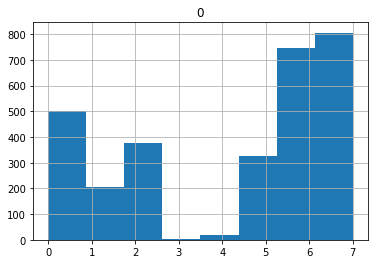

In [21]:
style_pred = pd.DataFrame(y_transformed)
print(style_pred[0].value_counts())
style_pred.hist(bins=8)

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# c_style = df_extended.label.unique()
enc = LabelEncoder().fit(y_unseen)
y_transformed = enc.transform(y_unseen)
df['labels_cat'] = y_transformed

feature_style = OneHotEncoder(handle_unknown='ignore').fit_transform(df[['labels_cat']]).toarray()

In [22]:
from sklearn.model_selection import train_test_split

''' Get inputs and outputs for model '''
ref_train, ref_test = train_test_split(dataset, test_size=0.2, random_state=42)

def get_x_y(refs):
    X, y = [], []
    idx = 0
    for ref in refs:
        X_ref, y_ref = [], []
        joined_ref = " ".join(list(map(lambda x: x[0], ref))) # concatenate tokens using whitespace
        # ner_features = generate_ner_features(joined_ref)
        scibert_features = get_scibert_vector(joined_ref)
        for token, tag in ref:
            features = scibert_features[token]
            # features = get_word_vector(token)
            # features = np.hstack([features, np.array(ner_features[token])])
            features = np.concatenate((features, feature_style[idx]), axis=None)
            X_ref.append(features)
            y_ref.append(tag_to_idx[tag])
            
        X.append(X_ref)
        y.append(y_ref)
        idx += 1
    return X, y

def add_padding(matrix, padding_value, max_length):
    return pad_sequences(matrix, maxlen=max_length, padding='post', truncating='pre', value=padding_value, dtype='float32')

X_train, y_train = get_x_y(ref_train)
X_test, y_test = get_x_y(ref_test)

padding_value = float(len(all_tags))
max_length = max(map(lambda ref: len(ref), X_train + X_test))

X_train = add_padding(X_train, padding_value, max_length)
X_test = add_padding(X_test, padding_value, max_length)
y_train = add_padding(y_train, padding_value, max_length)
y_test = add_padding(y_test, padding_value, max_length)

In [ ]:
# ##create another model trained with the hierarchy dataset
# dataset_hierarchy_path = "./dataset/hierarchy_dataset.txt"
# dataset_hierarchy = attach_tags(dataset_hierarchy_path)
# word_embedding_model = train_word_embedding_model(dataset_path, embedding_dim = EMBEDDING_DIM, use_subwords=False, use_hierarchy=True)
# all_tags = hierarchy_tags 
# all_tags.add(OTHER_TAG)
# all_tags.add(PUNCT_TAG)
# tag_to_idx, tag_arr = map_to_index(hierarchy_tags)

# ''' Get inputs and outputs for model '''
# hierarchy_ref_train, hierarchy_ref_test = train_test_split(dataset_hierarchy, test_size=0.2, random_state=42)

# X_hierarchy_train, y_hierarchy_train = get_x_y(hierarchy_ref_train)
# X_hierarchy_test, y_hierarchy_test = get_x_y(hierarchy_ref_test)

# hierarchy_padding_value = float(len(all_tags))
# hierarchy_max_length = max(map(lambda ref: len(ref), X_hierarchy_train + X_hierarchy_test))

# X_hierarchy_train = add_padding(X_hierarchy_train, hierarchy_padding_value, hierarchy_max_length)
# X_hierarchy_test = add_padding(X_hierarchy_test, hierarchy_padding_value, hierarchy_max_length)
# y_hierarchy_train = add_padding(y_hierarchy_train, hierarchy_padding_value, hierarchy_max_length)
# y_hierarchy_test = add_padding(y_hierarchy_test, hierarchy_padding_value, hierarchy_max_length)

In [23]:
from torch.nn.utils.rnn import pack_padded_sequence
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
    
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True
        )

    def forward(self, x):
        # Initialise hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Initialise internal state
        c0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size)

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h0, c0))

        return output, (hn, cn)


In [24]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = LSTM(input_size, hidden_size, output_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        output = self.fc(output)

        return output


In [25]:
'''
Hyperparameters
'''
num_epochs = 800
learning_rate = 0.001

we_feature_size = EMBEDDING_DIM
ner_feature_size = len(ner_dict.keys()) + 1
scibert_feature_size = 768

input_size = scibert_feature_size+feature_style.shape[1] # Number of features (change accordingly)
hidden_size = 25 # Number of features in the hidden state
num_layers = 1 # Number of stacked LSTM layers

output_size = len(all_tags) # Number of output classes

In [26]:
'''
Loss Function and Optimiser
'''
criterion = nn.CrossEntropyLoss(ignore_index=len(all_tags))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [27]:
import numpy as np
from torch.nn.utils.rnn import pad_packed_sequence
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix, confusion_matrix as cm
from sklearn.model_selection import KFold
from prettytable import PrettyTable
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

# X_train_hierarchy, y_train_hierarchy = torch.tensor(X_train_hierarchy), torch.tensor(y_train_hierarchy)
# X_test_hierarchy, y_test_hierarchy = torch.tensor(X_test_hierarchy), torch.tensor(y_test_hierarchy)

def categorical_accuracy(outputs, y, pad_index):
    max_outputs = outputs.argmax(dim = 1, keepdim=True)
    non_padded_elements = (y != pad_index).nonzero()
    correct = max_outputs[non_padded_elements].squeeze(1).eq(y[non_padded_elements])
    return correct.sum() / torch.FloatTensor([y[non_padded_elements].shape[0]])

def get_max_outputs(outputs):
    max_outputs = outputs.argmax(dim = -1)
    return max_outputs

def print_report(report):
    table = PrettyTable(float_format="1.5f")
    table.field_names = ["Tag", "Precision", "Recall", "FBeta"]
    for i in range(len(tag_arr)):
      tag, scores = [tag_arr[i]], list(map(lambda metric: metric[i], report))[:-1] # exclude support metric
      tag.extend(scores)
      table.add_row(tag)
    print(table)

def print_statistics(X_test, y_test, y_pred, model):
    macro_score = f1_score(y_test, y_pred, average='macro')
    micro_score = f1_score(y_test, y_pred, average='micro')
    cMtx = cm(y_test, y_pred)
    normalized_cMtx = []
    for row in cMtx:
        total = sum(row)
        if total != 0:
            row = list(map(lambda value: "{:.5f}".format(value / total), row))
        normalized_cMtx.append(row)
    print('Test F1 macro score: {}'.format(macro_score))
    print('Test F1 micro score: {}'.format(micro_score))
    print(normalized_cMtx)

def print_tags(y_pred, limit = 30):
    for i, ref_pred in enumerate(y_pred):
        if i == limit:
            return
        ref = ref_test[i]
        output = ""
        for index, token_tag in enumerate(ref):
            token, tag = token_tag[0], token_tag[1]
            output +=  ("[" + ", ".join([token, tag, tag_arr[ref_pred[index]]]) + "] ")
        print(output)

model = Net(input_size, hidden_size, output_size, num_layers)
# model_filename is used to save the model
def train(train_dataset, model_filename=None):
    train_loader = DataLoader(train_dataset, batch_size=256)
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader, 0):
            X_train, y_train = data
            outputs = model.forward(X_train)

            optimizer.zero_grad()

            outputs = outputs.view(-1, outputs.shape[-1]) # [batch_size * seq_len, output_dim]
            y_train = y_train.view(-1) # [batch_size * seq_len]
            
            # Get the loss function
            loss = criterion(outputs, y_train.long())

            # Calculate loss
            loss.backward()

            # Backpropagation
            optimizer.step()

            # Print loss at every 100th epoch
            if epoch % 100 == 0:
                print("Epoch: %d, loss after minibatch %5d: %1.5f" % (epoch, i+1, loss.item()))
        
        if epoch % 100 == 0:
            report = precision_recall_fscore_support(y_train.long(), \
                                                    get_max_outputs(outputs.detach()), \
                                                    average=None, \
                                                    zero_division=0, \
                                                    labels = [i for i in range(len(all_tags))])
            print_report(report)  

def test(X_test, y_test):
    with torch.no_grad():
        outputs = model.forward(X_test)

        outputs_squeezed = outputs.view(-1, outputs.shape[-1]) # [batch_size * seq_len, output_dim]
        y_test_squeezed = y_test.view(-1) # [batch_size * seq_len]

        # Get the loss function
        loss = criterion(outputs_squeezed, y_test_squeezed.long())
        
        int_y_test = y_test.int().tolist()
        output_probs = outputs
        y_true, y_pred = [], []
        for idx, row in enumerate(int_y_test):
            padding_idx = row.index(len(all_tags))
            y_true.extend(row[:padding_idx])
            test_row = output_probs[idx][:padding_idx]
            y_pred.extend(get_max_outputs(test_row))

        report = precision_recall_fscore_support(y_true, \
                                                y_pred, \
                                                average=None, \
                                                zero_division=0, \
                                                labels = [i for i in range(len(all_tags))])
        print_report(report)  
        print_statistics(X_test, y_true, y_pred, model)
        print_tags(get_max_outputs(outputs.detach()))

training_set = TensorDataset(X_train, y_train)
train(training_set)

model_filename = "test_model.pth" # change accordingly based on features being run
torch.save(model.state_dict(), "./models/" + str(model_filename)) # save trained model 

test(X_test, y_test)

In [ ]:
# training_set_hierarchy = TensorDataset(X_train_hierarchy, y_train_hierarchy)
# test_set_hierarchy = TensorDataset(X_test_hierarchy, y_test_hierarchy)
# concat_dataset_hierarchy = ConcatDataset([training_set_hierarchy, test_set_hierarchy])
# train(training_set_hierarchy, concat_dataset_hierarchy)
# evaluate(test_set_hierarchy)

In [31]:
model = Net(input_size, hidden_size, output_size, num_layers)
model.load_state_dict(torch.load("./models/test_model.pth"))
# model.load_state_dict(torch.load("./models/" + str(model_filename)))
test(X_test, y_test)


0742811952776
[['0.00000', '0.76471', '0.00000', '0.00000', '0.08824', '0.00000', '0.00000', '0.05882', '0.00000', '0.00000', '0.00000', '0.02941', '0.05882', '0.00000', '0.00000'], ['0.00000', '0.63229', '0.00897', '0.00000', '0.18386', '0.04036', '0.00000', '0.03139', '0.00448', '0.02242', '0.00897', '0.01345', '0.03587', '0.01345', '0.00448'], ['0.00000', '0.62996', '0.03360', '0.00000', '0.08276', '0.02180', '0.02278', '0.01377', '0.01344', '0.03343', '0.06752', '0.00344', '0.06342', '0.00983', '0.00426'], ['0.00000', '0.69489', '0.01944', '0.00000', '0.08307', '0.02050', '0.01225', '0.01438', '0.00825', '0.03701', '0.02849', '0.00426', '0.04819', '0.02077', '0.00852'], ['0.00000', '0.61111', '0.00000', '0.00000', '0.08333', '0.00000', '0.00000', '0.08333', '0.00000', '0.08333', '0.05556', '0.05556', '0.02778', '0.00000', '0.00000'], ['0.00000', '0.77477', '0.02703', '0.00000', '0.07207', '0.01802', '0.00000', '0.00000', '0.00000', '0.02703', '0.01802', '0.00000', '0.04505', '0.009

In [61]:
X_test[0]

tensor([[ 1.4051e-02,  1.6516e+00,  3.0878e-01,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-2.0966e-01,  1.3151e+00, -1.9022e-01,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [ 5.9372e-01,  1.8045e+00,  3.7534e-01,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        ...,
        [ 1.5000e+01,  1.5000e+01,  1.5000e+01,  ...,  1.5000e+01,
          1.5000e+01,  1.5000e+01],
        [ 1.5000e+01,  1.5000e+01,  1.5000e+01,  ...,  1.5000e+01,
          1.5000e+01,  1.5000e+01],
        [ 1.5000e+01,  1.5000e+01,  1.5000e+01,  ...,  1.5000e+01,
          1.5000e+01,  1.5000e+01]])